<a href="https://colab.research.google.com/github/ping-Mel/ERV-V2-Assignments/blob/main/session9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchsummary
from model import Models  #import all models classes
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

In [3]:
class CIFAR10Albumentations:
    def __init__(self, root='./data', train=True, transform=None):
        self.data = datasets.CIFAR10(root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            # Convert PIL image to numpy array
            image_np = np.array(image)
            # Apply the transformations
            augmented = self.transform(image=image_np)
            image = augmented['image']
        return image, label

In [4]:
# Train Phase transformations

mean_dataset = [0.4914 * 255, 0.4822 * 255, 0.4465 * 255]

train_transforms = A.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
                                       A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=mean_dataset, p=0.5),
                                       A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ToTensorV2()
                                      # Note the difference between (0.1307) and (0.1307,)
                                       ])


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                       ])

In [5]:
#train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train = CIFAR10Albumentations(root='./data', train=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 90666736.97it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def show_misclasses(failed_samples, title):
  CIFAR10_CLS = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
  }

  fig, axs = plt.subplots(5,2,figsize=(8,10))
  fig.suptitle(title, fontsize=16)

  for idx, (img, actual, pred) in enumerate(failed_samples[:10]):
      ax = axs[idx // 2, idx % 2]
      img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy and fix channel ordering
      img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
      ax.imshow(img, interpolation='none')
      ax.set_title(f'Actual: {CIFAR10_CLS[actual]}, Pred: {CIFAR10_CLS[pred]}')
      ax.axis('off')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

failed_samples = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # New code block to check for incorrect predictions
            matches = pred.eq(target.view_as(pred))
            for idx, match in enumerate(matches):
                if not match.item():
                    failed_samples.append((data[idx], target[idx].item(), pred[idx].item()))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


# Target: CNN Model for Image Classification 

## Define, Setup and Verify
- Implement DNN Architecture with Batch Normalization in Class **NetD**

## Aim
1.   **85+%** 
2.   Total RF must be more than 44
3.   one of the layers must use Depthwise Separable Convolution
4.   one of the layers must use Dilated Convolution
5.   use GAP (compulsory):- add FC after GAP to target #of classes (optional)
6.   use albumentation library (horizontal flip, shiftScaleRotate,coarseDropout  )
7.   No Limits to Epochs
8.   Less than **200k** Parameters

# Result: CNN Model for Image Classification

## Result Capture
Record the performance metrics such as loss and accuracy for both training and validation phases.

- Parameter: 109k

- Best Training Accuracy: EPOCH:39 (**53.51%**)

- Best Test Accuracy: EPOCH:35 (**61.30%**)

In [9]:
Models.evaluate_model(Models.NetD)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 15, 15]           7,168
              ReLU-2          [-1, 256, 15, 15]               0
           Dropout-3          [-1, 256, 15, 15]               0
            Conv2d-4            [-1, 128, 7, 7]           2,432
              ReLU-5            [-1, 128, 7, 7]               0
           Dropout-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          16,512
              ReLU-8            [-1, 128, 7, 7]               0
           Dropout-9            [-1, 128, 7, 7]               0
           Conv2d-10             [-1, 64, 4, 4]          73,792
             ReLU-11             [-1, 64, 4, 4]               0
          Dropout-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 16, 4, 4]           9,232
             ReLU-14             [-1, 1

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Models.NetD().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
EPOCHS =40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3016200065612793 Batch_id=195 Accuracy=10.25%: 100%|██████████| 196/196 [00:13<00:00, 14.37it/s]



Test set: Average loss: 2.3018, Accuracy: 1147/10000 (11.47%)

EPOCH: 1


Loss=2.259660005569458 Batch_id=195 Accuracy=12.85%: 100%|██████████| 196/196 [00:13<00:00, 14.80it/s]



Test set: Average loss: 2.2550, Accuracy: 1538/10000 (15.38%)

EPOCH: 2


Loss=2.160062074661255 Batch_id=195 Accuracy=19.25%: 100%|██████████| 196/196 [00:13<00:00, 14.64it/s]



Test set: Average loss: 2.0788, Accuracy: 2289/10000 (22.89%)

EPOCH: 3


Loss=1.988703966140747 Batch_id=195 Accuracy=23.57%: 100%|██████████| 196/196 [00:13<00:00, 14.62it/s]



Test set: Average loss: 1.9838, Accuracy: 2703/10000 (27.03%)

EPOCH: 4


Loss=1.8567321300506592 Batch_id=195 Accuracy=26.77%: 100%|██████████| 196/196 [00:13<00:00, 14.65it/s]



Test set: Average loss: 1.8870, Accuracy: 3030/10000 (30.30%)

EPOCH: 5


Loss=1.7056083679199219 Batch_id=195 Accuracy=29.54%: 100%|██████████| 196/196 [00:13<00:00, 14.59it/s]



Test set: Average loss: 1.7925, Accuracy: 3394/10000 (33.94%)

EPOCH: 6


Loss=1.9200528860092163 Batch_id=195 Accuracy=31.78%: 100%|██████████| 196/196 [00:13<00:00, 14.29it/s]



Test set: Average loss: 1.7464, Accuracy: 3570/10000 (35.70%)

EPOCH: 7


Loss=1.7662737369537354 Batch_id=195 Accuracy=33.86%: 100%|██████████| 196/196 [00:13<00:00, 14.48it/s]



Test set: Average loss: 1.6788, Accuracy: 3821/10000 (38.21%)

EPOCH: 8


Loss=1.7916843891143799 Batch_id=195 Accuracy=35.39%: 100%|██████████| 196/196 [00:13<00:00, 14.36it/s]



Test set: Average loss: 1.6064, Accuracy: 4062/10000 (40.62%)

EPOCH: 9


Loss=1.7588125467300415 Batch_id=195 Accuracy=37.44%: 100%|██████████| 196/196 [00:13<00:00, 14.33it/s]



Test set: Average loss: 1.5512, Accuracy: 4318/10000 (43.18%)

EPOCH: 10


Loss=1.7305166721343994 Batch_id=195 Accuracy=38.54%: 100%|██████████| 196/196 [00:13<00:00, 14.65it/s]



Test set: Average loss: 1.5171, Accuracy: 4443/10000 (44.43%)

EPOCH: 11


Loss=1.6704142093658447 Batch_id=195 Accuracy=39.64%: 100%|██████████| 196/196 [00:14<00:00, 13.94it/s]



Test set: Average loss: 1.4689, Accuracy: 4563/10000 (45.63%)

EPOCH: 12


Loss=1.485062837600708 Batch_id=195 Accuracy=40.58%: 100%|██████████| 196/196 [00:13<00:00, 14.47it/s]



Test set: Average loss: 1.4412, Accuracy: 4681/10000 (46.81%)

EPOCH: 13


Loss=1.5301682949066162 Batch_id=195 Accuracy=41.62%: 100%|██████████| 196/196 [00:13<00:00, 14.40it/s]



Test set: Average loss: 1.4171, Accuracy: 4787/10000 (47.87%)

EPOCH: 14


Loss=1.4716099500656128 Batch_id=195 Accuracy=42.32%: 100%|██████████| 196/196 [00:13<00:00, 14.69it/s]



Test set: Average loss: 1.4299, Accuracy: 4753/10000 (47.53%)

EPOCH: 15


Loss=1.4221111536026 Batch_id=195 Accuracy=43.23%: 100%|██████████| 196/196 [00:13<00:00, 14.64it/s]



Test set: Average loss: 1.3846, Accuracy: 4894/10000 (48.94%)

EPOCH: 16


Loss=1.533372163772583 Batch_id=195 Accuracy=43.71%: 100%|██████████| 196/196 [00:13<00:00, 14.31it/s]



Test set: Average loss: 1.3834, Accuracy: 4920/10000 (49.20%)

EPOCH: 17


Loss=1.5414233207702637 Batch_id=195 Accuracy=44.54%: 100%|██████████| 196/196 [00:13<00:00, 14.59it/s]



Test set: Average loss: 1.3337, Accuracy: 5114/10000 (51.14%)

EPOCH: 18


Loss=1.4417221546173096 Batch_id=195 Accuracy=44.72%: 100%|██████████| 196/196 [00:13<00:00, 14.52it/s]



Test set: Average loss: 1.3270, Accuracy: 5132/10000 (51.32%)

EPOCH: 19


Loss=1.6359230279922485 Batch_id=195 Accuracy=45.46%: 100%|██████████| 196/196 [00:14<00:00, 13.93it/s]



Test set: Average loss: 1.3241, Accuracy: 5233/10000 (52.33%)

EPOCH: 20


Loss=1.43174147605896 Batch_id=195 Accuracy=46.48%: 100%|██████████| 196/196 [00:13<00:00, 14.72it/s]



Test set: Average loss: 1.3091, Accuracy: 5232/10000 (52.32%)

EPOCH: 21


Loss=1.4054243564605713 Batch_id=195 Accuracy=46.88%: 100%|██████████| 196/196 [00:13<00:00, 14.64it/s]



Test set: Average loss: 1.2850, Accuracy: 5342/10000 (53.42%)

EPOCH: 22


Loss=1.5349245071411133 Batch_id=195 Accuracy=47.29%: 100%|██████████| 196/196 [00:13<00:00, 14.62it/s]



Test set: Average loss: 1.2636, Accuracy: 5475/10000 (54.75%)

EPOCH: 23


Loss=1.3238320350646973 Batch_id=195 Accuracy=47.41%: 100%|██████████| 196/196 [00:13<00:00, 14.75it/s]



Test set: Average loss: 1.2463, Accuracy: 5536/10000 (55.36%)

EPOCH: 24


Loss=1.6797634363174438 Batch_id=195 Accuracy=48.33%: 100%|██████████| 196/196 [00:13<00:00, 14.68it/s]



Test set: Average loss: 1.2329, Accuracy: 5581/10000 (55.81%)

EPOCH: 25


Loss=1.3569811582565308 Batch_id=195 Accuracy=48.44%: 100%|██████████| 196/196 [00:13<00:00, 14.62it/s]



Test set: Average loss: 1.2557, Accuracy: 5410/10000 (54.10%)

EPOCH: 26


Loss=1.3485995531082153 Batch_id=195 Accuracy=48.86%: 100%|██████████| 196/196 [00:13<00:00, 14.62it/s]



Test set: Average loss: 1.2070, Accuracy: 5680/10000 (56.80%)

EPOCH: 27


Loss=1.378284215927124 Batch_id=195 Accuracy=49.79%: 100%|██████████| 196/196 [00:13<00:00, 14.79it/s]



Test set: Average loss: 1.1957, Accuracy: 5674/10000 (56.74%)

EPOCH: 28


Loss=1.582829236984253 Batch_id=195 Accuracy=49.76%: 100%|██████████| 196/196 [00:13<00:00, 14.70it/s]



Test set: Average loss: 1.2092, Accuracy: 5600/10000 (56.00%)

EPOCH: 29


Loss=1.4327986240386963 Batch_id=195 Accuracy=50.63%: 100%|██████████| 196/196 [00:14<00:00, 13.32it/s]



Test set: Average loss: 1.1746, Accuracy: 5832/10000 (58.32%)

EPOCH: 30


Loss=1.3898155689239502 Batch_id=195 Accuracy=51.02%: 100%|██████████| 196/196 [00:13<00:00, 14.54it/s]



Test set: Average loss: 1.1813, Accuracy: 5820/10000 (58.20%)

EPOCH: 31


Loss=1.2445259094238281 Batch_id=195 Accuracy=51.00%: 100%|██████████| 196/196 [00:13<00:00, 14.64it/s]



Test set: Average loss: 1.1540, Accuracy: 5901/10000 (59.01%)

EPOCH: 32


Loss=1.3903712034225464 Batch_id=195 Accuracy=51.22%: 100%|██████████| 196/196 [00:13<00:00, 14.83it/s]



Test set: Average loss: 1.1558, Accuracy: 5848/10000 (58.48%)

EPOCH: 33


Loss=1.322676181793213 Batch_id=195 Accuracy=51.61%: 100%|██████████| 196/196 [00:15<00:00, 12.62it/s]



Test set: Average loss: 1.1375, Accuracy: 5974/10000 (59.74%)

EPOCH: 34


Loss=1.2560547590255737 Batch_id=195 Accuracy=52.22%: 100%|██████████| 196/196 [00:13<00:00, 14.49it/s]



Test set: Average loss: 1.1754, Accuracy: 5852/10000 (58.52%)

EPOCH: 35


Loss=1.2044597864151 Batch_id=195 Accuracy=52.20%: 100%|██████████| 196/196 [00:13<00:00, 14.70it/s]



Test set: Average loss: 1.0818, Accuracy: 6130/10000 (61.30%)

EPOCH: 36


Loss=1.1437582969665527 Batch_id=195 Accuracy=52.48%: 100%|██████████| 196/196 [00:13<00:00, 14.37it/s]



Test set: Average loss: 1.0985, Accuracy: 6114/10000 (61.14%)

EPOCH: 37


Loss=1.2453938722610474 Batch_id=195 Accuracy=52.84%: 100%|██████████| 196/196 [00:13<00:00, 14.59it/s]



Test set: Average loss: 1.1026, Accuracy: 6108/10000 (61.08%)

EPOCH: 38


Loss=1.3184343576431274 Batch_id=195 Accuracy=53.24%: 100%|██████████| 196/196 [00:14<00:00, 13.54it/s]



Test set: Average loss: 1.1095, Accuracy: 6040/10000 (60.40%)

EPOCH: 39


Loss=1.271062970161438 Batch_id=195 Accuracy=53.51%: 100%|██████████| 196/196 [00:15<00:00, 12.47it/s]



Test set: Average loss: 1.0874, Accuracy: 6126/10000 (61.26%)



Text(0.5, 1.0, 'Test Accuracy')

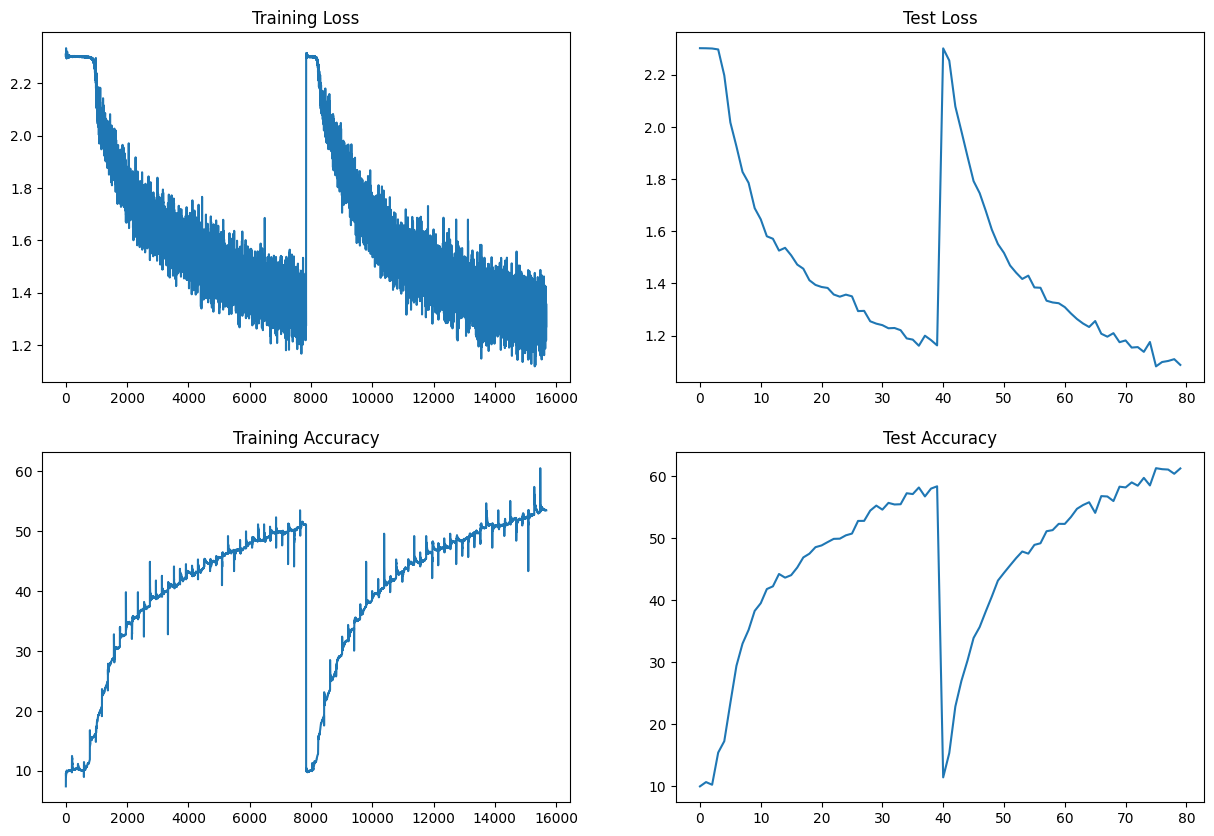

In [16]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

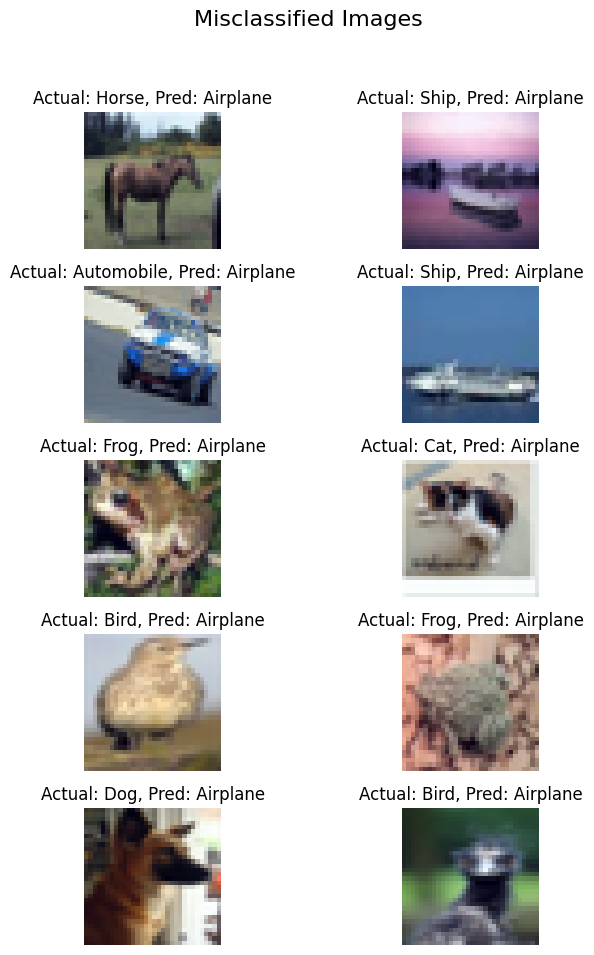

In [17]:
show_misclasses(failed_samples,"Misclassified Images ")

# Analysis: CNN Model for Image Classification


**Current Accuracy:** Reached 61.26% on the validation set, demonstrating the model's effectiveness.
**Parameter Efficiency:** With only 100K parameters, the model is lightweight yet performs robustly.
**Potential Improvements:** Given more time for model tuning and expanded data augmentation, there's potential to achieve even higher accuracy.

---
---
---